In [1]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from xml.etree import ElementTree as et
#from torch_snippets import *

from IPython import display 
display.set_matplotlib_formats('svg')

from PIL import Image
from PIL import ImageFont, ImageDraw

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


https://blog.paperspace.com/train-yolov5-custom-data/

In [2]:
class_name_to_id_mapping = {"apple": 0,
                           "banana": 1,
                           "orange": 2}

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in target: 
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        a.add_patch(rect)
    plt.show()
    
def color_image(img): 
    image = cv2.imread(img)
    image = cv2.cvtColor(image,  cv2.COLOR_BGR2RGB)
    return image 

def read_content(xml_file: str):
    # https://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python
    tree = et.parse(xml_file)
    root = tree.getroot()
    
    #print(root.find('filename').text)
    yolo_list = []
    list_with_all_boxes = []
    
    filename = root.find('filename').text
    image_w = int(root.find("size/width").text)
    image_h = int(root.find("size/height").text)
    image_c = int(root.find("size/depth").text)
    
    for boxes in root.iter('object'):

        ymin, xmin, ymax, xmax = None, None, None, None
        
        name = boxes.find("name").text
        
        class_id = class_name_to_id_mapping[name]
        
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        
        
        
        b_center_x = (xmin + xmax) / 2 
        b_center_y = (ymin + ymax) / 2
        b_width    = (xmax - xmin)
        b_height   = (ymax - ymin)
        
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        yolo_item = [class_id, b_center_x, b_center_y, b_width, b_height]
        yolo_list.append(yolo_item)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes, yolo_list

read_content('../input/fruit-images-for-object-detection/test_zip/test/apple_77.xml')

('apple_77.jpg',
 [[71, 60, 175, 164],
  [12, 22, 105, 111],
  [134, 23, 243, 115],
  [107, 126, 216, 229],
  [207, 138, 298, 229]],
 [[0, 0.41, 0.4890829694323144, 0.3466666666666667, 0.45414847161572053],
  [0, 0.195, 0.2903930131004367, 0.31, 0.388646288209607],
  [0,
   0.6283333333333333,
   0.30131004366812225,
   0.36333333333333334,
   0.4017467248908297],
  [0,
   0.5383333333333333,
   0.7751091703056768,
   0.36333333333333334,
   0.4497816593886463],
  [0,
   0.8416666666666667,
   0.8013100436681223,
   0.30333333333333334,
   0.39737991266375544]])

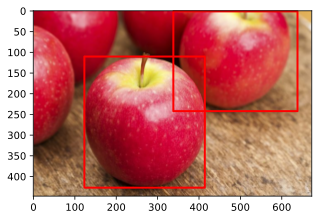

In [3]:
img_path = '../input/fruit-images-for-object-detection/test_zip/test/apple_94.jpg'
anns_path = '../input/fruit-images-for-object-detection/test_zip/test/apple_94.xml'

image = color_image(img_path)
filename, bboxes, _ = read_content(anns_path)

plot_img_bbox(image, bboxes)

# https://www.kaggle.com/code/yerramvarun/fine-tuning-faster-rcnn-using-pytorch/notebook

In [4]:
class CustomDataset(Dataset): 
    def __init__(self, file_dir, width, height, feature_extractor=None): 
        self.width = width 
        self.height = height 
        self.file_dir = file_dir
        self.feature_extractor = feature_extractor
        
        self.img = [i for i in os.listdir(file_dir) if i.endswith('.jpg')]  # Getting only the images 
        self.xml = [f'{i[:-4]}.xml' for i in self.img]  # chaning the image name to xml file. 
        self.classes = [_,'apple', 'banana', 'orange'] # labels of the images. 
        
    def __len__(self): 
        return len(self.img)
    
    def __getitem__(self, index): 
        img_name = self.img[index]  # indexing the image list 
        ann_name = self.xml[index]  # indexing the xml list 
        
        image_path = f'{self.file_dir}/{img_name}'  # making path for image path 
        ann_path = f'{self.file_dir}/{ann_name}' # making path for anns path 
        
        #image = color_image(image_path) # read the file and give the RGB format of the file! 
        #image_res = image.astype(np.float32)
        #image_res = cv2.resize(image_res, (self.width, self.height), cv2.INTER_AREA)
        #image_res /= 255.0  
        image_res = Image.open(image_path).convert('RGB')#.resize(self.width, self.height)
         
        
        wt = image.shape[1]
        ht = image.shape[0]
        
        tree = et.parse(ann_path)
        root = tree.getroot()
        
        list_with_all_boxes = []
        labels = []
        for boxes in root.iter('object'):
            labels.append(self.classes.index(boxes.find('name').text))

            ymin, xmin, ymax, xmax = None, None, None, None

            ymin = int(boxes.find("bndbox/ymin").text)
            xmin = int(boxes.find("bndbox/xmin").text)
            ymax = int(boxes.find("bndbox/ymax").text)
            xmax = int(boxes.find("bndbox/xmax").text)
            
            # The COCO bounding box format is [top left x position, top left y position, width, height].
            coco_xmin = xmin
            coco_ymin = ymin
            coco_width = xmax - xmin
            coco_height = ymax - ymin
            
            xmin_corr = (xmin/wt)*self.width 
            xmax_corr = (xmax/wt)*self.width 
            ymin_corr = (ymin/ht)*self.height 
            ymax_corr = (ymax/ht)*self.height 
                
            #list_with_single_boxes = [xmin_corr, ymin_corr, xmax_corr, ymax_corr]
            
            coco_list_with_single_boxes = [coco_xmin, coco_ymin, coco_width, coco_height]
            
            line = {'category_id': self.classes.index(boxes.find('name').text), 'bbox': coco_list_with_single_boxes, 'area': 1.0}
            
            #list_with_all_boxes.append(list_with_single_boxes)
            list_with_all_boxes.append(line)
            
        target = {}
        #target['boxes'] = list_with_all_boxes
        #target['labels'] = labels  
        #target['image_id'] = index 
        
        target['annotations'] = list_with_all_boxes
        #target['category_id'] = labels  
        target['image_id'] = index 
        
        
        if self.feature_extractor:
            return feature_extractor(images=image_res, annotations=target, return_tensors="pt")
        else:
            return image_res, target
        

In [5]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)

Downloading:   0%|          | 0.00/275 [00:00<?, ?B/s]

In [6]:
file_dir_train = '../input/fruit-images-for-object-detection/train_zip/train'
file_dir_test = '../input/fruit-images-for-object-detection/test_zip/test'

# Getting the dataset 
train_set = CustomDataset(file_dir_train, 224, 224, feature_extractor=feature_extractor)
test_set = CustomDataset(file_dir_test, 224, 224, feature_extractor=feature_extractor)

print(len(train_set), len(test_set))

# Let's get validation test 
train_set, valid_set = torch.utils.data.random_split(train_set, [190, 50])


def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['labels'] = labels
    return batch


# Data Loader 
train_dataloader = DataLoader(train_set, batch_size = 1, shuffle = True, num_workers = 1)
val_dataloader = DataLoader(valid_set, batch_size = 1, shuffle = True, num_workers = 1)
test_loader = DataLoader(test_set, batch_size = 1, shuffle = False, num_workers = 1)
#train_dataloader = DataLoader(train_set, collate_fn=collate_fn, batch_size=1, shuffle=True)
#valid_dataloader = DataLoader(valid_set, collate_fn=collate_fn, batch_size=1)
#test_loader = DataLoader(test_set, collate_fn=collate_fn, batch_size=1)


240 60


In [7]:
test_set[9]["pixel_values"].shape
train_set[2]['labels']

[{'boxes': tensor([[0.4540, 0.6378, 0.7140, 0.6410],
          [0.5566, 0.6104, 0.4588, 0.4898]]),
  'class_labels': tensor([2, 1]),
  'image_id': tensor([96]),
  'area': tensor([0.1752, 0.1752]),
  'iscrowd': tensor([0, 0]),
  'orig_size': tensor([1223, 1360]),
  'size': tensor([512, 569])}]

(683, 512)
tensor([0.2130, 0.3554, 0.2313, 0.3461])
tensor(66.4787) tensor(93.3808) tensor(224.4793) tensor(270.5765)
tensor([0.2743, 0.6001, 0.2127, 0.2607])
tensor(114.7440) tensor(240.5125) tensor(259.9953) tensor(373.9786)
tensor([0.5653, 0.1495, 0.5067, 0.2117])
tensor(213.0960) tensor(22.3203) tensor(559.1493) tensor(130.7331)
tensor([0.5947, 0.2989, 0.4693, 0.2278])
tensor(245.8800) tensor(94.7473) tensor(566.4346) tensor(211.3594)
tensor([0.5950, 0.3892, 0.5153, 0.2429])
tensor(230.3987) tensor(137.1103) tensor(582.3713) tensor(261.4662)


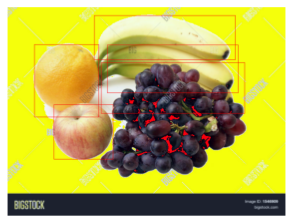

In [8]:
tensor = test_set[9]['pixel_values'][0]
boxes = test_set[9]['labels'][0]['boxes']

tensor = 0.225 * tensor + 0.456

img = T.ToPILImage()(tensor)

print(img.size)
plt.figure(figsize=(5, 5))

draw = ImageDraw.Draw(img)
for box in boxes:
    print(box)
    x1, y1, w_size, h_size = box[0], box[1], box[2], box[3] 
    x_start = (x1 - (w_size/2)) * img.size[0]
    y_start = (y1 - (h_size/2)) * img.size[1]
    x_end = (x_start + w_size * img.size[0]) 
    y_end = (y_start + h_size * img.size[1]) 
    print(x_start, y_start, x_end, y_end)
    draw.rectangle(((x_start, y_start), (x_end, y_end)), outline ="red")
    
plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
from transformers import DetrConfig, AutoModelForObjectDetection

#model = Detr(lr=2.5e-5, weight_decay=1e-4)
model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-small", num_labels=3, ignore_mismatched_sizes=True)

lr=2.5e-5
weight_decay=1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
#model

Downloading:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/117M [00:00<?, ?B/s]

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([4, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
if torch.cuda.is_available():  
    model.cuda()

In [11]:
for epoch_num in range(40):
    train_loss = 0
    train_loss_ce = 0
    train_loss_bbox = 0
    valid_loss = 0
    valid_loss_ce = 0
    valid_loss_bbox = 0
    loss = 0
    
    # Train loop   
    model.train()
    #print("Train step")
    for ii, batch in enumerate(iter(train_dataloader)):
        #print(batch["labels"])
        pixel_values = batch['pixel_values'][0]
        
        if torch.cuda.is_available():
            pixel_values = pixel_values.cuda()
            

        if torch.cuda.is_available():  
            labels = [{k: v[0].cuda() for k, v in t.items()} for t in batch['labels']]
        else:
            labels = [{k: v[0] for k, v in t.items()} for t in batch['labels']]
        
        #print(labels)
        
        outputs = model(pixel_values=pixel_values, labels=labels)
        
        #print(outputs)

        loss += outputs.loss
        if (ii+1)%4 == 0:       
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss = 0
        
        #train_loss += loss.item()
        train_loss_ce += outputs.loss_dict['loss_ce'].item()
        train_loss_bbox += outputs.loss_dict['loss_bbox'].item()
        
        #if ii%10 == 0:
        #    print("Iter {}, Loss = {:.4f} {:.4f} {:.4f}".format(ii, loss.item(), outputs.loss_dict['loss_ce'].item(), outputs.loss_dict['loss_bbox'].item()))

    # Valid loop 
    model.eval()
    #print("Eval step")
    for ii, batch in enumerate(iter(val_dataloader)):
        
        if torch.cuda.is_available():
            pixel_values = pixel_values.cuda()
        
        if torch.cuda.is_available():  
            labels = [{k: v[0].cuda() for k, v in t.items()} for t in batch['labels']]
        else:
            labels = [{k: v[0] for k, v in t.items()} for t in batch['labels']]
        
        outputs = model(pixel_values=pixel_values, labels=labels)

        #loss = outputs.loss
        
        #valid_loss += loss.item()
        valid_loss_ce += outputs.loss_dict['loss_ce'].item()
        valid_loss_bbox += outputs.loss_dict['loss_bbox'].item()
        
    print("Epoch {}, Train loss {:.4f}, CE={:.4f}, BBOX={:.4f}".format(epoch_num+1, train_loss, train_loss_ce, train_loss_bbox))
    print("Epoch {}, Valid loss {:.4f}, CE={:.4f}, BBOX={:.4f}".format(epoch_num+1, valid_loss, valid_loss_ce, valid_loss_bbox))

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1, Train loss 0.0000, CE=108.8384, BBOX=13.4664
Epoch 1, Valid loss 0.0000, CE=19.3878, BBOX=13.0182


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 2, Train loss 0.0000, CE=62.9403, BBOX=12.8516
Epoch 2, Valid loss 0.0000, CE=22.0227, BBOX=14.6596


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 3, Train loss 0.0000, CE=54.4391, BBOX=12.5230
Epoch 3, Valid loss 0.0000, CE=25.4745, BBOX=16.7054


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 4, Train loss 0.0000, CE=46.5090, BBOX=10.6086
Epoch 4, Valid loss 0.0000, CE=26.8630, BBOX=10.8270


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 5, Train loss 0.0000, CE=41.9149, BBOX=10.2017
Epoch 5, Valid loss 0.0000, CE=28.5671, BBOX=14.0173


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 6, Train loss 0.0000, CE=39.5156, BBOX=9.4179
Epoch 6, Valid loss 0.0000, CE=26.5253, BBOX=12.8276


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 7, Train loss 0.0000, CE=37.6935, BBOX=8.7890
Epoch 7, Valid loss 0.0000, CE=32.3063, BBOX=16.0421


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 8, Train loss 0.0000, CE=34.1236, BBOX=8.8709
Epoch 8, Valid loss 0.0000, CE=40.7739, BBOX=15.9734


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 9, Train loss 0.0000, CE=32.6670, BBOX=7.8458
Epoch 9, Valid loss 0.0000, CE=46.4817, BBOX=12.4516


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 10, Train loss 0.0000, CE=32.1775, BBOX=8.3032
Epoch 10, Valid loss 0.0000, CE=32.3239, BBOX=13.0931


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 11, Train loss 0.0000, CE=31.1887, BBOX=8.5105
Epoch 11, Valid loss 0.0000, CE=29.2756, BBOX=12.7837


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 12, Train loss 0.0000, CE=26.6579, BBOX=8.1268
Epoch 12, Valid loss 0.0000, CE=39.2500, BBOX=13.4799


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 13, Train loss 0.0000, CE=24.5165, BBOX=7.5772
Epoch 13, Valid loss 0.0000, CE=37.8472, BBOX=22.8705


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 14, Train loss 0.0000, CE=20.8204, BBOX=8.1121
Epoch 14, Valid loss 0.0000, CE=35.4451, BBOX=12.9450


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 15, Train loss 0.0000, CE=18.0615, BBOX=7.5411
Epoch 15, Valid loss 0.0000, CE=37.5812, BBOX=17.4770


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 16, Train loss 0.0000, CE=16.0071, BBOX=7.6204
Epoch 16, Valid loss 0.0000, CE=46.0169, BBOX=15.5114


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 17, Train loss 0.0000, CE=13.7588, BBOX=6.8026
Epoch 17, Valid loss 0.0000, CE=28.9622, BBOX=12.1834


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 18, Train loss 0.0000, CE=12.4816, BBOX=6.6912
Epoch 18, Valid loss 0.0000, CE=41.0125, BBOX=15.2255


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 19, Train loss 0.0000, CE=11.4677, BBOX=6.6927
Epoch 19, Valid loss 0.0000, CE=42.9699, BBOX=14.7934


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 20, Train loss 0.0000, CE=9.2948, BBOX=6.3521
Epoch 20, Valid loss 0.0000, CE=34.4075, BBOX=12.4054


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 21, Train loss 0.0000, CE=9.3401, BBOX=6.2523
Epoch 21, Valid loss 0.0000, CE=47.7734, BBOX=12.7954


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 22, Train loss 0.0000, CE=11.3824, BBOX=6.3422
Epoch 22, Valid loss 0.0000, CE=57.4337, BBOX=13.2198


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 23, Train loss 0.0000, CE=12.3126, BBOX=5.8770
Epoch 23, Valid loss 0.0000, CE=44.0654, BBOX=19.7982


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 24, Train loss 0.0000, CE=9.6125, BBOX=6.0207
Epoch 24, Valid loss 0.0000, CE=49.0185, BBOX=14.3348


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 25, Train loss 0.0000, CE=8.1094, BBOX=5.1419
Epoch 25, Valid loss 0.0000, CE=52.7571, BBOX=12.9351


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 26, Train loss 0.0000, CE=7.7010, BBOX=5.1616
Epoch 26, Valid loss 0.0000, CE=41.9520, BBOX=14.7543


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 27, Train loss 0.0000, CE=7.5465, BBOX=5.4836
Epoch 27, Valid loss 0.0000, CE=49.5253, BBOX=12.7446


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 28, Train loss 0.0000, CE=7.1425, BBOX=4.8491
Epoch 28, Valid loss 0.0000, CE=49.1704, BBOX=14.9117


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 29, Train loss 0.0000, CE=7.8079, BBOX=5.5325
Epoch 29, Valid loss 0.0000, CE=41.6707, BBOX=13.7724


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 30, Train loss 0.0000, CE=5.9721, BBOX=4.9313
Epoch 30, Valid loss 0.0000, CE=46.0772, BBOX=14.9162


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 31, Train loss 0.0000, CE=6.1951, BBOX=4.9241
Epoch 31, Valid loss 0.0000, CE=58.6372, BBOX=13.2857


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 32, Train loss 0.0000, CE=6.5113, BBOX=4.9133
Epoch 32, Valid loss 0.0000, CE=63.3000, BBOX=14.8690


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 33, Train loss 0.0000, CE=4.6699, BBOX=4.4825
Epoch 33, Valid loss 0.0000, CE=44.9918, BBOX=14.7764


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 34, Train loss 0.0000, CE=3.9554, BBOX=4.7232
Epoch 34, Valid loss 0.0000, CE=62.1241, BBOX=13.0386


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 35, Train loss 0.0000, CE=2.5617, BBOX=4.3675
Epoch 35, Valid loss 0.0000, CE=58.2136, BBOX=13.8412


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 36, Train loss 0.0000, CE=2.4427, BBOX=4.3354
Epoch 36, Valid loss 0.0000, CE=52.6967, BBOX=14.2352


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 37, Train loss 0.0000, CE=2.1796, BBOX=4.1146
Epoch 37, Valid loss 0.0000, CE=64.5733, BBOX=14.4853


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 38, Train loss 0.0000, CE=2.7932, BBOX=3.9395
Epoch 38, Valid loss 0.0000, CE=60.1430, BBOX=14.2149


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 39, Train loss 0.0000, CE=2.4975, BBOX=3.8634
Epoch 39, Valid loss 0.0000, CE=49.6152, BBOX=12.4489


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 40, Train loss 0.0000, CE=2.1093, BBOX=3.5652
Epoch 40, Valid loss 0.0000, CE=58.6966, BBOX=16.6514


[{'boxes': tensor([[0.5101, 0.7090, 0.9437, 0.5480],
        [0.6059, 0.4506, 0.7252, 0.3870],
        [0.5664, 0.2924, 0.6194, 0.3814]]), 'class_labels': tensor([2, 2, 2]), 'image_id': tensor([79]), 'area': tensor([2.0913, 2.0913, 2.0913]), 'iscrowd': tensor([0, 0, 0]), 'orig_size': tensor([354, 444]), 'size': tensor([512, 642])}]
(642, 512)
1 35 260 609 503 0.50168 2
7 159 133 624 331 0.9617212 2
18 27 272 634 502 0.6707268 2
25 13 245 638 502 0.40554604 2
33 39 231 638 503 0.51877266 2
41 27 274 637 504 0.72549427 2
54 69 195 626 469 0.95638484 2
83 26 230 639 504 0.7696169 2
84 36 242 637 503 0.70596737 2
88 26 234 638 504 0.6932984 2
96 167 49 562 251 0.992488 2


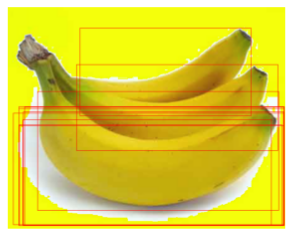

In [12]:
def test_pred(i, thr=0.4):
    batch = train_set[i]
    pixel_values = batch['pixel_values']#[0]
    outputs = model(pixel_values=pixel_values.cuda())

    #outputs
    print(batch['labels'])

    outputs_softmax = torch.softmax(outputs.logits.detach(), dim=-1)[0, :, :-1]
    probs = torch.max(outputs_softmax, dim=-1).values.cpu()
    pred_class = torch.max(outputs_softmax, dim=-1).indices.cpu()

    tensor = pixel_values[0].cpu()
    boxes = outputs.pred_boxes[0].cpu().detach().numpy()

    tensor = 0.225 * tensor + 0.456

    img = T.ToPILImage()(tensor)

    print(img.size)
    plt.figure(figsize=(5, 5))

    draw = ImageDraw.Draw(img)
    for n, box in enumerate(boxes):
        #print(box)
        x1, y1, w_size, h_size = box[0], box[1], box[2], box[3] 
        x_start = (x1 - (w_size/2)) * img.size[0]
        y_start = (y1 - (h_size/2)) * img.size[1]
        x_end = (x_start + w_size * img.size[0]) 
        y_end = (y_start + h_size * img.size[1]) 

        if probs[n]>thr:
            print(n, int(x_start), int(y_start), int(x_end), int(y_end), probs[n].numpy(), pred_class[n].numpy())
            draw.rectangle(((x_start, y_start), (x_end, y_end)), outline ="red")

    plt.imshow(img)
    plt.axis('off')
    plt.show()
test_pred(0)

[{'boxes': tensor([[0.5792, 0.5652, 0.6550, 0.8323]]), 'class_labels': tensor([3]), 'image_id': tensor([48]), 'area': tensor([1.1236]), 'iscrowd': tensor([0]), 'orig_size': tensor([483, 600]), 'size': tensor([512, 636])}]
(636, 512)


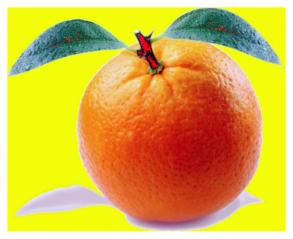

[{'boxes': tensor([[0.4540, 0.6378, 0.7140, 0.6410],
        [0.5566, 0.6104, 0.4588, 0.4898]]), 'class_labels': tensor([2, 1]), 'image_id': tensor([96]), 'area': tensor([0.1752, 0.1752]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([1223, 1360]), 'size': tensor([512, 569])}]
(569, 512)
41 54 154 463 496 0.8924856 2
86 188 187 443 433 0.98417145 1


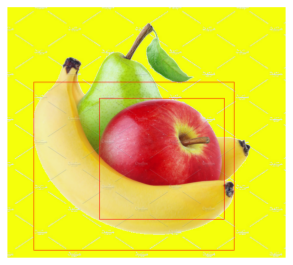

[{'boxes': tensor([[0.2899, 0.4095, 0.5673, 0.7123],
        [0.7171, 0.3557, 0.5364, 0.6728]]), 'class_labels': tensor([3, 3]), 'image_id': tensor([238]), 'area': tensor([0.2215, 0.2215]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([1088, 1292]), 'size': tensor([512, 608])}]
(608, 512)


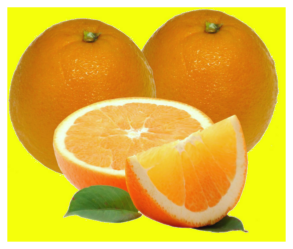

[{'boxes': tensor([[0.4910, 0.5205, 0.8855, 0.8421]]), 'class_labels': tensor([1]), 'image_id': tensor([163]), 'area': tensor([9.5055]), 'iscrowd': tensor([0]), 'orig_size': tensor([171, 166]), 'size': tensor([527, 512])}]
(512, 527)
58 23 53 478 502 0.94274604 1
94 26 52 477 501 0.9220718 1


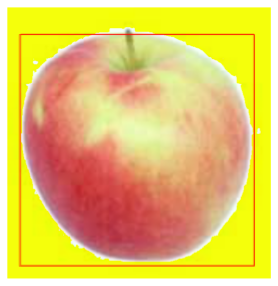

[{'boxes': tensor([[0.3885, 0.5882, 0.7741, 0.7014]]), 'class_labels': tensor([3]), 'image_id': tensor([36]), 'area': tensor([0.5567]), 'iscrowd': tensor([0]), 'orig_size': tensor([720, 686]), 'size': tensor([537, 512])}]
(512, 537)


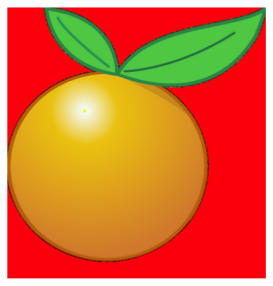

[{'boxes': tensor([[0.5259, 0.5124, 0.9482, 0.9243]]), 'class_labels': tensor([3]), 'image_id': tensor([212]), 'area': tensor([0.0676]), 'iscrowd': tensor([0]), 'orig_size': tensor([1969, 1969]), 'size': tensor([512, 512])}]
(512, 512)


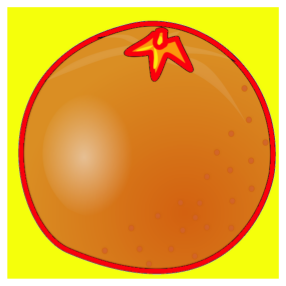

[{'boxes': tensor([[0.2542, 0.4064, 0.3500, 0.5920],
        [0.6193, 0.3504, 0.3427, 0.5152]]), 'class_labels': tensor([3, 3]), 'image_id': tensor([221]), 'area': tensor([0.6707, 0.6707]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([625, 960]), 'size': tensor([512, 786])}]
(786, 512)


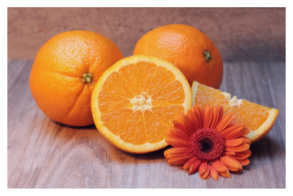

[{'boxes': tensor([[0.7153, 0.5436, 0.2274, 0.5835],
        [0.5484, 0.5412, 0.1355, 0.6320],
        [0.4121, 0.5557, 0.1177, 0.5787],
        [0.2718, 0.5702, 0.1532, 0.5738]]), 'class_labels': tensor([2, 2, 2, 2]), 'image_id': tensor([22]), 'area': tensor([1.5356, 1.5356, 1.5356, 1.5356]), 'iscrowd': tensor([0, 0, 0, 0]), 'orig_size': tensor([413, 620]), 'size': tensor([512, 768])}]
(768, 512)
11 460 128 635 431 0.9915547 2
62 369 115 473 443 0.9946015 2
67 272 133 363 439 0.9796944 2
92 150 146 269 439 0.9740898 2


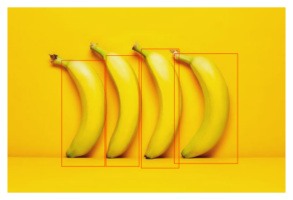

[{'boxes': tensor([[0.5423, 0.4173, 0.8015, 0.4392],
        [0.4150, 0.4360, 0.7254, 0.4714]]), 'class_labels': tensor([2, 2]), 'image_id': tensor([81]), 'area': tensor([0.2096, 0.2096]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([1118, 1300]), 'size': tensor([512, 595])}]
(595, 512)
62 85 97 561 332 0.9944929 2
97 30 99 461 349 0.9867154 2


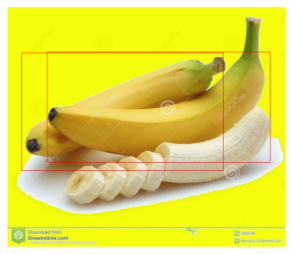

[{'boxes': tensor([[0.7115, 0.5436, 0.5710, 0.7038]]), 'class_labels': tensor([1]), 'image_id': tensor([91]), 'area': tensor([3.1774]), 'iscrowd': tensor([0]), 'orig_size': tensor([287, 338]), 'size': tensor([512, 602])}]
(602, 512)
70 256 98 600 463 0.9991584 1


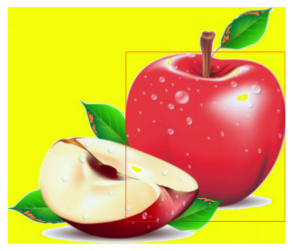

[{'boxes': tensor([[0.5149, 0.4940, 0.8513, 0.8996]]), 'class_labels': tensor([3]), 'image_id': tensor([222]), 'area': tensor([4.2271]), 'iscrowd': tensor([0]), 'orig_size': tensor([249, 269]), 'size': tensor([512, 553])}]
(553, 512)


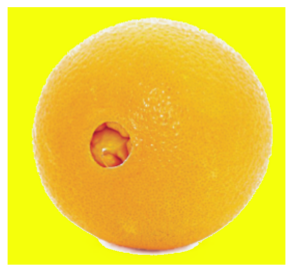

[{'boxes': tensor([[0.4153, 0.3936, 0.7365, 0.4468],
        [0.6671, 0.6188, 0.5247, 0.7624],
        [0.4776, 0.5337, 0.6871, 0.5284]]), 'class_labels': tensor([2, 2, 2]), 'image_id': tensor([124]), 'area': tensor([3.2937, 3.2937, 3.2937]), 'iscrowd': tensor([0, 0, 0]), 'orig_size': tensor([282, 425]), 'size': tensor([512, 771])}]
(771, 512)
30 309 123 718 512 0.9978618 2
94 107 139 629 406 0.99428177 2
97 38 88 601 311 0.9944483 2


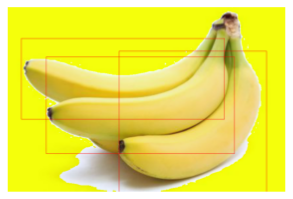

[{'boxes': tensor([[0.2822, 0.6400, 0.2775, 0.4544]]), 'class_labels': tensor([1]), 'image_id': tensor([219]), 'area': tensor([0.4003]), 'iscrowd': tensor([0]), 'orig_size': tensor([ 768, 1366]), 'size': tensor([486, 864])}]
(864, 486)
45 124 201 365 427 0.9971103 1


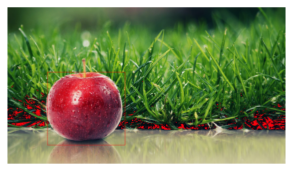

[{'boxes': tensor([[0.6006, 0.3435, 0.5914, 0.6852],
        [0.7537, 0.7912, 0.4926, 0.3917]]), 'class_labels': tensor([3, 3]), 'image_id': tensor([217]), 'area': tensor([0.2247, 0.2247]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([1080, 1620]), 'size': tensor([512, 768])}]
(768, 512)


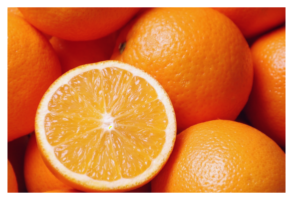

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[{'boxes': tensor([[0.4614, 0.5426, 0.7378, 0.8125]]), 'class_labels': tensor([1]), 'image_id': tensor([47]), 'area': tensor([2.1126]), 'iscrowd': tensor([0]), 'orig_size': tensor([352, 389]), 'size': tensor([512, 565])}]
(565, 512)
58 49 69 471 489 0.9936028 1
86 49 69 471 488 0.9735851 1


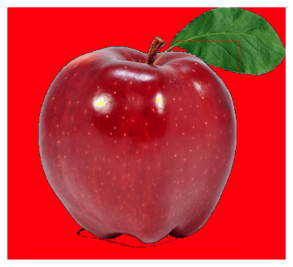

[{'boxes': tensor([[0.4810, 0.5520, 0.8700, 0.8840]]), 'class_labels': tensor([1]), 'image_id': tensor([156]), 'area': tensor([1.0486]), 'iscrowd': tensor([0]), 'orig_size': tensor([500, 500]), 'size': tensor([512, 512])}]
(512, 512)
58 23 57 471 511 0.9781989 1


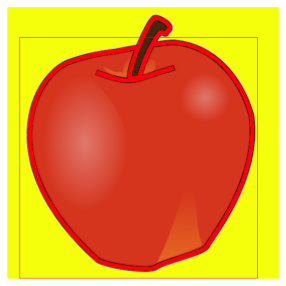

[{'boxes': tensor([[0.6097, 0.4866, 0.4354, 0.4955],
        [0.7494, 0.2218, 0.4512, 0.4407],
        [0.1722, 0.2574, 0.3428, 0.5059],
        [0.1088, 0.6810, 0.2160, 0.6231],
        [0.3916, 0.8331, 0.4012, 0.3338],
        [0.8424, 0.8561, 0.3136, 0.2878]]), 'class_labels': tensor([2, 2, 2, 2, 2, 2]), 'image_id': tensor([0]), 'area': tensor([0.5196, 0.5196, 0.5196, 0.5196, 0.5196, 0.5196]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0]), 'orig_size': tensor([ 674, 1199]), 'size': tensor([486, 864])}]
(864, 486)
6 449 1 834 219 0.9650621 2
21 163 325 515 488 0.9926317 2
43 0 2 298 253 0.97213405 2
72 587 346 864 486 0.98191065 2
86 340 111 708 357 0.9977005 2
88 0 178 191 486 0.9827513 2


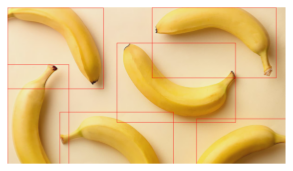

[{'boxes': tensor([[0.2056, 0.6243, 0.1919, 0.3286],
        [0.4411, 0.6957, 0.2113, 0.3571],
        [0.5113, 0.3186, 0.1710, 0.2714],
        [0.6427, 0.1514, 0.2177, 0.2971],
        [0.7750, 0.2971, 0.1952, 0.3314],
        [0.6145, 0.4500, 0.1839, 0.3057]]), 'class_labels': tensor([1, 1, 1, 1, 1, 1]), 'image_id': tensor([207]), 'area': tensor([1.9430, 1.9430, 1.9430, 1.9430, 1.9430, 1.9430]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0]), 'orig_size': tensor([350, 620]), 'size': tensor([488, 864])}]
(864, 488)
6 461 1 644 150 0.98297274 1
7 448 146 609 296 0.9954796 1
19 289 252 473 433 0.9976417 1
20 582 67 750 227 0.55531704 1
69 582 65 751 228 0.99625266 1
81 366 88 512 225 0.9861596 1
92 92 226 261 393 0.99699926 1


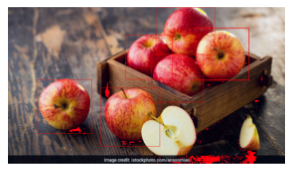

[{'boxes': tensor([[0.5384, 0.5841, 0.6081, 0.5382],
        [0.5293, 0.4207, 0.5638, 0.4501]]), 'class_labels': tensor([2, 2]), 'image_id': tensor([184]), 'area': tensor([1.0033, 1.0033]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([511, 768]), 'size': tensor([512, 769])}]
(769, 512)
13 184 161 649 441 0.9869407 2
99 195 98 618 336 0.9778763 2


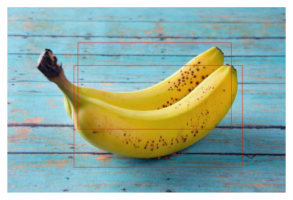

In [13]:
for i in range(1, 20):
    test_pred(i)